In [1]:
%matplotlib inline

# TPB04 : Régression : modélisation du diffusiomètre NSCAT

### Introduction 
A l’aide des Perceptrons Multicouches (PMC), on veut simuler la fonction directe d’un diffusiomètre satellitaire mais aussi estimer la variance.  

Le diffusiomètre est un radar actif d’observation de la surface océanique (actif car il possède son propre source d’illumination de la surface d’observation, par rapport à d’autres radars dits passifs qui utilisent le rayonnement solaire). Son principe de mesure est basé sur la réflexion diffuse des ondes électromagnétiques qu’il a émises et qui sont diffusées dans toutes les directions par la surface océanique.  
Le coefficient de rétrodiffusion qu’il mesure est le rapport entre la puissance diffusée dans la direction du radar donc rétrodiffusée et la puissance incidente émise. Ce coefficient de rétrodiffusion (noté ***sigma0*** ou ***s0***) dépend de la rugosité de la surface de l’océan, de la géométrie de mesure (angle de visée ou d’incidence ***q***) et des caractéristiques du radar (la fréquence du signal utilisé, la polarisation des ondes électromagnétiques). 
La rugosité de surface dépend au premier ordre d’approximation du vent local soufflant sur la surface. Le vent engendre,
par l’intermédiaire d’une force de frottement, des vaguelettes de quelques centimètres de ***LO***   (longueur d’onde ou la distance entre 2 crêtes) qui elles interagissent avec les ondes émises par le radar, ondes aussi de quelques centimètres de ***LO***, selon les caractéristiques radars utilisées

Le diffusiomètre effectue des mesures à incidence oblique (***q*** entre 20$^oC$ et 50$^oC$), plus le vent est fort, plus la diffusion est importante et donc plus la mesure radar est forte. En résumé : à vent fort, diffusion plus importante dans toutes les directions et signal mesuré fort, tandis qu’à vent faible, faible diffusion dans la direction du radar et donc signal mesuré plus faible. 
Dans le cadre de ce projet, le diffusiomètre est NSCAT de la NASA. Il travaille en bande Ku ( 14 GHz ) et effectue des mesures en polarisations verticale ( VV ) et horizontale ( HH ) de ***s0*** .


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor

## Chargement des données

Les données mises à disposition sont constituées d’une base de données issue du radar NSCAT du satellite SeaScat. 
Leur taille et d’un peu plus de 4000 exemples. 4 fichiers sont inclus :
 * Diffu_Dir.dat : Angle d'azimut (en degré) ou direction du vent (***c***)
 * Diffu_Inc.dat : Angle d'incidence (en degré) du signal (***q***)
 * Diffu_Vit.dat : Module de la vitesse du vent : ***n*** (en m/s).
 * Diffu_Sig.dat : ***Sigma0*** (ou s0), composante HH uniquement (en ***dB***)
 
Cette base n'est pas égalisée (voir histogrammes de fréquences ci-dessous), il y a bien plus d'exemples pour les basses vitesses que pour les hautes. Certains angles d'azimut sont mieux représentés que d'autres.

In [3]:
# Chargement des donnees brutes,
direction = np.loadtxt("Diffu_Dir.dat")[:,None]
vitesse    = np.loadtxt("Diffu_Vit.dat")[:,None]
incidence = np.loadtxt("Diffu_Inc.dat")[:,None]
sigma0    = np.loadtxt("Diffu_Sig.dat")[:,None]

In [4]:
len(np.array(list(filter(lambda x: (58<=x <=62),direction))))

29

In [5]:
len(np.array(list(filter(lambda x: (58<=x <=62),direction))))

29

In [6]:
direction_sin = np.sin(direction/180*np.pi)
direction_cos = np.cos(direction/180*np.pi)

In [7]:
X = np.hstack((direction,direction_sin,direction_cos,vitesse,incidence,sigma0))
variables = ['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']
nombreDeDonnees   = len(sigma0)

In [8]:
df = pd.DataFrame(X,columns=variables)
df.describe()

,Direction,Direction (sin),Direction (cos),Vitesse,Incidence,Sigma0
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,188.441481,0.010634,-0.012867,8.281703,34.535776,-16.132584
std,102.283310,0.710321,0.703854,3.868725,0.296186,5.249319
min,0.350000,-1.000000,-0.999993,0.930000,33.800000,-45.410000
25%,110.842500,-0.709877,-0.716058,5.580000,34.360000,-18.427500
50%,173.825000,0.058784,-0.007505,7.700000,34.530000,-15.570000
75%,288.825000,0.718126,0.680529,10.357500,34.670000,-12.820000
max,359.990000,1.000000,1.000000,28.050000,35.300000,-4.810000


In [9]:
df.corr()

,Direction,Direction (sin),Direction (cos),Vitesse,Incidence,Sigma0
Direction,1.000000,-0.798955,0.185444,-0.035217,0.193240,-0.025902
Direction (sin),-0.798955,1.000000,-0.214886,0.067687,-0.174956,0.044729
Direction (cos),0.185444,-0.214886,1.000000,-0.010067,0.065495,0.123095
Vitesse,-0.035217,0.067687,-0.010067,1.000000,-0.115581,0.762851
Incidence,0.193240,-0.174956,0.065495,-0.115581,1.000000,-0.112924
Sigma0,-0.025902,0.044729,0.123095,0.762851,-0.112924,1.000000


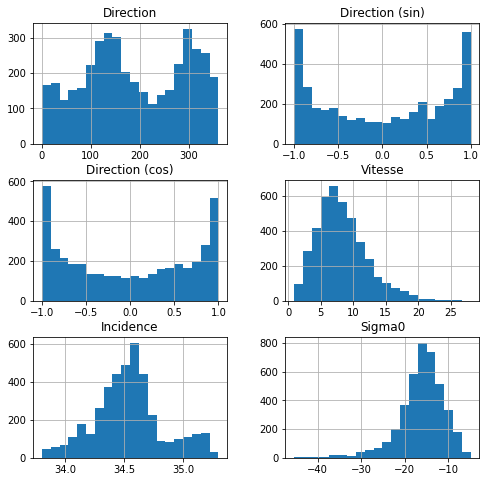

In [10]:
#ax = df.iloc[:,0].plot.hist(bins=12, alpha=0.5)
hist = df.hist(bins=20,figsize=(8,8))

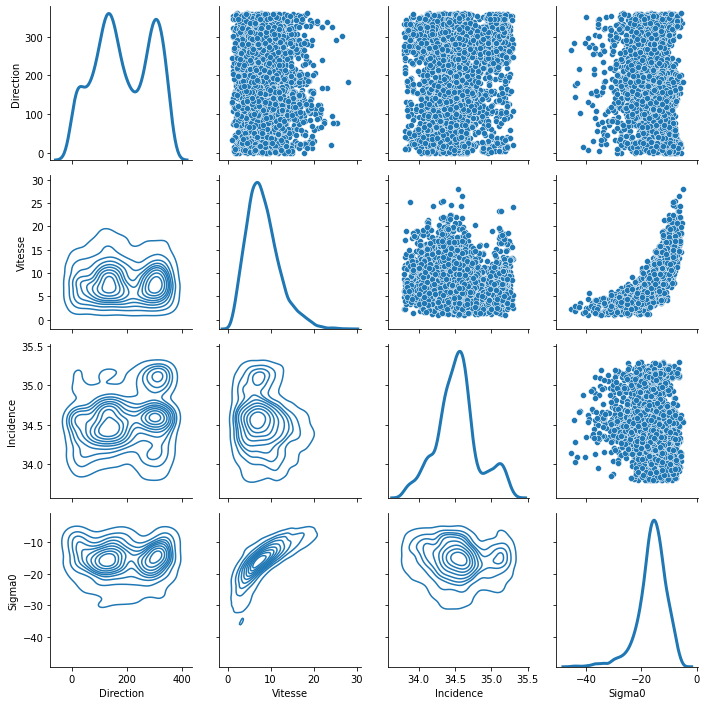

In [11]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))
g = sns.PairGrid(df[['Direction','Vitesse','Incidence','Sigma0']], diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

In [12]:
if False:
    g = sns.PairGrid(df[['Direction','Direction (sin)','Direction (cos)','Sigma0']], diag_sharey=False)
    g.map_lower(sns.kdeplot)
    g.map_upper(sns.scatterplot)
    g.map_diag(sns.kdeplot, lw=3)

### Mise en forme et codages des entrées et des sorties du réseau de neurone

In [13]:
#
# moyennes et écarts types,
direction_moyenne = np.mean(direction)
direction_sin_moyenne = np.mean(direction_sin)
direction_cos_moyenne = np.mean(direction_cos)
vitesse_moyenne = np.mean(vitesse)
incidence_moyenne = np.mean(incidence)
sigma0_moyenne = np.mean(sigma0)

# ecart-types
direction_et = np.std(direction)
direction_sin_et = np.std(direction_sin)
direction_cos_et = np.std(direction_cos)
vitesse_et = np.std(vitesse);
incidence_et = np.std(incidence);
sigma0_et = np.std(sigma0)

#
# Donnees normalisees et matrice d'entree
DirN    = (direction - direction_moyenne ) /  direction_et  * 2/3
Dir_sinN    = (direction_sin - direction_sin_moyenne ) /  direction_sin_et  * 2/3
Dir_cosN    = (direction_cos - direction_cos_moyenne ) /  direction_cos_et  * 2/3
VitN    = (vitesse   - vitesse_moyenne   ) /  vitesse_et  * 2/3
IncN    = (incidence - incidence_moyenne ) / incidence_et * 2/3
SigN    = (sigma0    - sigma0_moyenne    ) / sigma0_et    * 2/3
#
XN      = np.concatenate((Dir_sinN,Dir_cosN, VitN), axis=1)

In [14]:
# pour la suite, on cree des intervalles reguliers en vitesse et direction 
vit_grid = np.linspace(vitesse.min(),vitesse.max(),10)
vitN_grid = (vit_grid   - vitesse_moyenne   ) /  vitesse_et  * 2/3

dir_grid  = np.linspace(direction.min(),direction.max(),100)
dirN_grid = (dir_grid - direction_moyenne ) /  direction_et  * 2/3
dir_sin_grid  = np.sin(dir_grid/180*np.pi)
dir_sinN_grid = (dir_sin_grid - direction_sin_moyenne ) /  direction_sin_et  * 2/3
dir_cos_grid  = np.cos(dir_grid/180*np.pi)
dir_cosN_grid = (dir_cos_grid - direction_cos_moyenne ) /  direction_cos_et  * 2/3

#inc_grid = np.linspace(incidence.min(),incidence.max(),100)

## 1 ère Partie : Modélisation du diffusiomètre NSCAT

Nous vous demandons de réaliser une régression par PMC pour modéliser la fonction du
diffusiomètre NSCAT. Le rôle du PMC sera donc de donner la valeur de sortie Sigma0 en fonction
de la direction et de la vitesse du vent.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, SigN_train, SigN_test,VitNTrain,_,Dir_sinNTrain,_,Dir_cosNTrain,_ = train_test_split(XN, SigN,VitN,Dir_sinN,Dir_cosN, test_size=0.33, random_state=42)

In [33]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))

df_train = pd.DataFrame(X_train)
df_train.columns = ['DirSinN','DirCosN','VitesN']
df_train['Sigma0'] = y_train
g = sns.PairGrid(df_train, diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

NameError: name 'y_train' is not defined

In [ ]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))

df_test = pd.DataFrame(X_test)
df_test.columns = ['DirSinN','DirCosN','VitesN']
df_test['Sigma0'] = y_test
g = sns.PairGrid(df_test, diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
pt1 = PowerTransformer()
pt2 = PowerTransformer()

In [ ]:
pt1.fit(SigN_train)
SigN_train = pt1.transform(SigN_train)
SigN_train.shape

In [ ]:
pt2.fit(X_train)
X_train = pt2.transform(X_train)
X_train.shape

In [ ]:
#np.concatenate((SigN_train), axis=1)

In [ ]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))

df_train = pd.DataFrame(X_train)
df_train.columns = ['DirSinN','DirCosN','VitesN']
df_train['Sigma0'] = SigN_train
g = sns.PairGrid(df_train, diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

In [ ]:
n_hidden = (5,)
# specification du modele
rgrsr_esperance = MLPRegressor(activation='tanh', hidden_layer_sizes = n_hidden, 
                     warm_start='True',solver='lbfgs', 
                     early_stopping=True, 
                     learning_rate = 'adaptive',max_iter=100000)
rgrsr_esperance = rgrsr_esperance.fit(X_train, SigN_train.ravel())
YN = rgrsr_esperance.predict(X_train)
Y = YN * 3/2 * sigma0_et + sigma0_moyenne

In [ ]:
rgrsr_esperance.score(pt2.transform(X_test),pt1.transform(SigN_test))

In [ ]:
rgrsr_esperance.score(X_train, SigN_train.ravel())

In [ ]:
YN = pt1.inverse_transform(np.expand_dims(YN, axis=1)).squeeze()

In [ ]:
SigN_train = pt1.inverse_transform(SigN_train)

In [ ]:
YN.shape

### Apprentissage du mlp

In [ ]:
len(df_train)

In [ ]:
import smogn
housing_smogn = smogn.smoter(
    data = df_train, 
    y =  'Sigma0'
)

In [ ]:
housing_smogn

In [ ]:
X_train = housing_smogn[['DirSinN','DirCosN','VitesN']].values
SigN_train = housing_smogn['Sigma0'].values

In [ ]:
n_hidden = 5,5
# specification du modele
rgrsr_esperance = MLPRegressor(activation='tanh', hidden_layer_sizes = n_hidden, 
                     warm_start='True',solver='lbfgs', 
                     early_stopping=True, 
                     learning_rate = 'adaptive',max_iter=100000)
rgrsr_esperance = rgrsr_esperance.fit(X_train, SigN_train.ravel())
YN = rgrsr_esperance.predict(X_train)
Y = YN * 3/2 * sigma0_et + sigma0_moyenne

In [ ]:
YN = rgrsr_esperance.predict(X_test)

In [ ]:
rgrsr_esperance.score(X_train,SigN_train)

In [ ]:
rgrsr_esperance.score(X_test,SigN_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
svr = svr.fit(X_train, SigN_train.ravel())

In [ ]:
svr.score(X_train,SigN_train)

In [ ]:
svr.score(pt2.transform(X_test),pt1.transform(SigN_test))

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
np.arange(3,10)

array([3, 4, 5, 6, 7, 8, 9])

In [27]:
#regr_1 = DecisionTreeRegressor(max_depth=6)
regr_1 = GridSearchCV(DecisionTreeRegressor(),param_grid={"max_depth":np.arange(2,4)})
regr_1 = regr_1.fit(X_train, SigN_train.ravel())

In [28]:
regr_1.score(X_train,SigN_train)

0.6446261978846157

In [29]:
regr_1.score(pt2.transform(X_test),pt1.transform(SigN_test))

0.6626858518264694

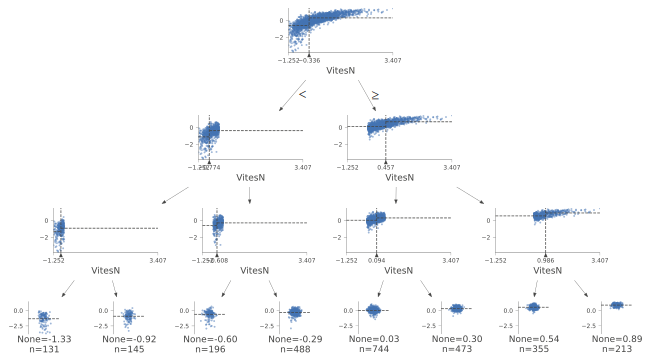

In [31]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(regr_1.best_estimator_, X_train, SigN_train,
                feature_names=['DirSinN','DirCosN','VitesN'])
viz


In [25]:
YN = regr_1.predict(X_train)

In [ ]:
YN = pt1.inverse_transform(np.expand_dims(YN, axis=1)).squeeze()
SigN_train = pt1.inverse_transform(SigN_train)

In [ ]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(regr_1.best_estimator_, out_file='tree.dot')

In [ ]:
#fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr_1.best_estimator_, 
                   feature_names=['DirSinN','DirCosN','VitesN'],  
                   filled=True)


In [ ]:
!pip install dtreeviz

In [ ]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))


g = sns.PairGrid(housing_smogn, diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

### Visualisation et affichage de la fonction estimée

#### Quelques fonctions

In [ ]:
def tracerLesDonneesEnCouleur(x,y,c,nombreDeClasses = 100,cb_label=''):
    classes_edges = np.linspace(c.min(),c.max(),nombreDeClasses)
    classes_edges[0] , classes_edges[-1] = -np.infty, np.infty
    classes_indices = np.digitize(c,classes_edges)

    cmap = matplotlib.cm.hot
    cmap = matplotlib.cm.jet
    norm = matplotlib.cm.colors.Normalize(vmin=c.min(), vmax=c.max())
    colors = cmap(np.linspace(0,1,nombreDeClasses))
    for k in range(nombreDeClasses): # boucle sur les mois
        selec_classes = np.where(classes_indices==k)
        if len(selec_classes[0]) != 0:
            h = plt.plot(x[selec_classes], y[selec_classes[0]],'.', color=colors[k])

            
    ax = plt.gca()
    pos1 = ax.get_position() # get the original position 
    if False:
        pos2 = [pos1.x0, pos1.y0+pos1.height*.125,  pos1.width , pos1.height*.85] 
        pos3 = [pos1.x0, pos1.y0,  pos1.width , pos1.height*.025] 
        orientation='horizontal'
    else:
        pos2 = [pos1.x0, pos1.y0,  pos1.width*.825 , pos1.height] 
        pos3 = [pos1.x0+pos1.width*.85, pos1.y0,  pos1.width*.025 , pos1.height] 
        orientation='vertical'
            
    ax.set_position(pos2) #
    ax_cb = fig.add_axes(pos3)    
    cb = matplotlib.colorbar.ColorbarBase(ax_cb,cmap=cmap,
                                          norm=norm, 
                                          orientation=orientation)
    #cb.set_label(cb_label)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel(cb_label, rotation=270)

    plt.sca(ax)
    
    return colors, classes_edges 

In [ ]:
#Affichage de l'erreur selon la vitesse

#### Affichage de la fonction estimée avec une entrée connue

In [ ]:
fig, ax = plt.subplots(1,figsize=(16,8))
colors, classes_edges = tracerLesDonneesEnCouleur(direction,sigma0,vitesse,nombreDeClasses = 100,cb_label="Vitesse")

classes_regr_indices = np.digitize(vit_grid,classes_edges)
for v,k in zip(vitN_grid,classes_regr_indices):
    xN_tmp = np.concatenate((dir_sinN_grid[:,None],dir_cosN_grid[:,None], v*np.ones(dirN_grid.shape)[:,None]), axis=1)
    xN_tmp = pt2.transform(xN_tmp)
    yN_tmp = regr_1.predict(xN_tmp)
    yN_tmp = np.expand_dims(yN_tmp, axis=1)
    yN_tmp = pt1.inverse_transform(yN_tmp)
    y_tmp = yN_tmp* 3/2 * sigma0_et + sigma0_moyenne
    plt.plot(dir_grid,y_tmp,color=colors[k])
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("$\sigma_0$ [$dB$]")
plt.xlabel("Direction [$^oC$]") ;

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(Dir_sinNTrain,YN,VitNTrain,nombreDeClasses = 100,cb_label="Vitesse")
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("coefficient de retrodiffusion (normalisé) estimé : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Direction normalisée []")

#### Affichage du diagramme de dispersion

In [ ]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
SigN_train_origin = pt1.inverse_transform(SigN_train)
#YN = pt1.transform(YN)
plt.plot(SigN_train,YN,'.b')
plt.plot(SigN_train,SigN_train)
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.subplot(1,2,2)
plt.plot(SigN_train,SigN_train-YN[:,None],'.b')

plt.title("Résidus")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.ylabel("résidus : $\sigma_{0,N}-\hat{\sigma}_{0,N}$ []") ;


In [ ]:
len(VitNTrain)

#### Affichage des diagrammes de dispersion (avec informations supplémentaires sur les entrées)

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = [ [fig.add_axes((.05,.05,.4,.4)),fig.add_axes((.55,.05,.4,.4))],
       [fig.add_axes((.05,.55,.4,.4)),fig.add_axes((.55,.55,.4,.4))] ]

#plt.subplot(2,2,1)
plt.sca(ax[0][0])
tracerLesDonneesEnCouleur(SigN,YN,VitNTrain,nombreDeClasses = 100,cb_label="Vitesse")
plt.plot(SigN,SigN)
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
#plt.subplot(2,2,2)
plt.sca(ax[0][1])
tracerLesDonneesEnCouleur(SigN,YN,Dir_sinNTrain,nombreDeClasses = 100,cb_label="Direction")
plt.plot(SigN,SigN)
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.tight_layout()
#plt.subplot(2,2,3)
plt.sca(ax[1][0])
tracerLesDonneesEnCouleur(SigN,YN,Dir_cosNTrain,nombreDeClasses = 100,cb_label="cos(Dir)")
plt.plot(SigN,SigN)
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
#plt.subplot(2,2,4)
plt.sca(ax[1][1])
tracerLesDonneesEnCouleur(SigN,YN,Dir_sinNTrain,nombreDeClasses = 100,cb_label="sin(Dir)")
plt.plot(SigN,SigN)
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []") ;

#plt.tight_layout() 

#### Affichage des Résidus en fonction de la direction

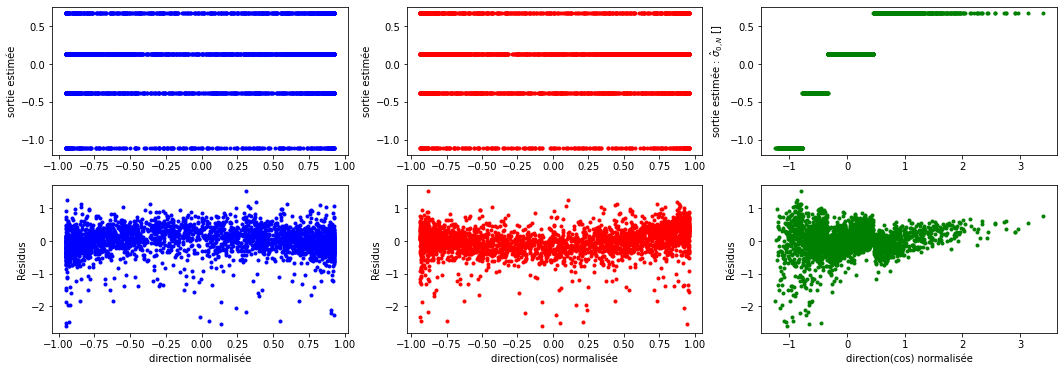

In [26]:
plt.figure(figsize=(18,6))
#
plt.subplot(2,3,1)
plt.plot(Dir_sinNTrain,YN[:,None],'.b')
plt.ylabel("sortie estimée")
plt.subplot(2,3,4)
plt.plot(Dir_sinNTrain,SigN_train-YN[:,None],'.b')
plt.ylabel("Résidus")
plt.xlabel("direction normalisée")
#
plt.subplot(2,3,2)
plt.plot(Dir_cosNTrain,YN[:,None],'.r')
plt.ylabel("sortie estimée")
plt.subplot(2,3,5)
plt.plot(Dir_cosNTrain,SigN_train-YN[:,None],'.r')
plt.ylabel("Résidus")
plt.xlabel("direction(cos) normalisée")
#
plt.subplot(2,3,3)
plt.plot(VitNTrain,YN[:,None],'.g')
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.subplot(2,3,6)
plt.plot(VitNTrain,SigN_train-YN[:,None],'.g')
plt.ylabel("Résidus")
plt.xlabel("direction(cos) normalisée") ;
#


## 2 ème Partie : Encadrement par approximation de la variance

Afin d’attacher des intervalles de confiance aux résultats trouvés, on propose d’estimer la
variance du bruit en fonction des données. La méthode proposée a déjà été mise en œuvre dans un
TP précédent.